# Taking scope data for N sources

In [3]:
# import packages
import pyvisa # intefacing with oscilloscope
import numpy as np # math/general purpose
import matplotlib.pyplot as plt # plotting
import os # file/directory access
from tqdm import tqdm # progress bar
import time
from datetime import datetime

In [6]:
# Connect to Oscilloscope
rm = pyvisa.ResourceManager()
print(rm.list_resources()) # List all resources pyVISA is detecting
# find 'USB0::0x0699::0x052C...'. <-- this is the oscilloscope

('ASRL1::INSTR', 'ASRL2::INSTR', 'USB0::0x0699::0x052C::C016084::INSTR')


In [7]:
addr = rm.list_resources()[2] # select correct resource
print(addr)

scope = rm.open_resource(addr)

# For future commands
scope.read_termination = '\n'
scope.write_termination = '\n'

print(scope.query('*IDN?')) # print scope info

USB0::0x0699::0x052C::C016084::INSTR
TEKTRONIX,MDO34,C016084,CF:91.1CT FV:v1.12.15


In [8]:
def initChannel(ch, Vscale, pos):
    if ch == 0: raise Error('Remember channel # starts from 1.')
    scope.write(f'CH{ch}:BANdwidth FULl') # full bandwidth of 350 MHz
    scope.write(f'CH{ch}:COUPling DC') # set to DC coupling
    scope.write(f'CH{ch}:POSition {pos}') # set the postition of the waveform to be N divisions above center.
    scope.write(f'CH{ch}:OFFSet 0') # set to zero DC offset
    scope.write(f'CH{ch}:TERmination FIFty') # set the channel termination to 50 Ohms
    scope.write(f'CH{ch}:SCAle {Vscale}')  # set the vertical scale in Volts

def initTrigger(ch, Vthres):
    if ch == 0: raise Error('Remember channel # starts from 1.')
    scope.write('TRIGger:A:MODe NORMAL') # normal trigger mode
    scope.write('TRIGger:A:TYPe EDGE') # trigger on the rising or falling edge
    scope.write('TRIGger:A:EDGE:COUPLING DC') # arguments are 'DC' or 'AC'
    scope.write('TRIGger:A:EDGE:SLOpe RISE') # arguments are 'FALL', 'RISE', or 'EITHer'
    scope.write(f'TRIGger:A:EDGE:SOUrce CH{ch}')
    scope.write(f'TRIGger:A:LEVel:CH{ch} {Vthres}') # sets the threshold for CH{ch} in Volts
    scope.write('TRIGer:A:HOLDoff:TIMe 1.E-06') # set the trigger holdoff to 1.e-6 seconds (1 microsecond)
    
def getRunConfig(ch):  
    if ch == 0: raise Error('Remember channel # starts from 1.')
    scope.write(f'DATa:SOUrce CH{ch}')
    scope.write('DATa:STARt 1')
    scope.write('DATa:STOP 1000')
    scope.write('DATa:ENCdg ASCIi')
    scope.write('DATa:WIDth 2')
    scope.write('HEADer 0') # set this to 1 if you want header info to help you understand the output
    scope.write('VERBose 1')

    runconfig = {}
    runconfig['npt']    = float(scope.query('WFMOutpre:NR_Pt?'))
    runconfig['x_inc']  = float(scope.query('WFMOutpre:XINCr?'))
    runconfig['x_zero'] = float(scope.query('WFMOutpre:XZEro?'))
    runconfig['y_mult'] = float(scope.query('WFMOutpre:YMUlt?'))
    runconfig['y_off']  = float(scope.query('WFMOutpre:YOFf?'))
    runconfig['y_zero'] = float(scope.query('WFMOutpre:YZEro?'))
    return runconfig

In [9]:
scope.write('DISplay:TRIGFrequency ON') # turn on the trigger frequency counter
scope.write('ACQuire:MODe SAMple') # turn on SAMple or HIRes acquisition
scope.write('HORizontal:SCAle 100.0E-09')  # set the horizontal time scale
scope.write('HORizontal:POSition 50')  # set the horizontal position in % (could have just been 10%)
scope.write('HORizontal:RECOrdlength 1000') # set the number of samples to record

initChannel(ch=1, Vscale=1, pos=-4) # comparator
initChannel(ch=2, Vscale=0.02, pos=-3) # SiPM 1
initChannel(ch=3, Vscale=0.02, pos=-3) # SiPM 2
initChannel(ch=4, Vscale=0.1, pos=3) # PMT

#initTrigger(ch=4, Vthres=-0.04)
initTrigger(ch=1, Vthres=2)

channels = [1,2,3,4]
runconfig = []
for ch in channels:
    runconfig.append(getRunConfig(ch))

In [10]:
def get_trigrate(nTime):
    started = False
    scope.write("ACQuire:FASTAcq:STATE OFF")
    time.sleep(1)
    scope.write("ACQuire:FASTAcq:STATE ON")
    time.sleep(nTime)
    nEvents = int(scope.query("ACQ:NUMAC?"))
    print(f"Trigger Rate (Hz): {nEvents/nTime}")
    return nEvents/nTime

In [11]:
def take_data(nEvents, scope, channels, runConfig):
    events = []
    curves = []
    trace_count = 0
    scope.write("ACQuire:FASTAcq:STATE OFF")
    scope.write('ACQuire:MODe SAMple')
    scope.write("ACQuire:STOPAfter RUNSTop")
    time.sleep(1)

    # start
    scope.write("ACQuire:STATE ON")
    print("Started!")
    while trace_count < nEvents:
        curves_i = []
        for ch in channels:
            scope.write(f'DATa:SOUrce CH{ch}')
            curve = scope.query(':CURVE?')
            
            if len(curves) > 0 and curve == curves[-1][0]:
                break # duplicate, don't save
                
            curves_i.append(curve)
            
        if len(curves_i) > 0:
            curves.append(curves_i)
            trace_count += 1
            if trace_count%100 == 0: print(trace_count, end="..")
        
    for curves_i in curves:
        events_i = []
        for ch in range(len(curves_i)):
            curve = curves_i[ch]
            
            samples = curve.split(',')
            samples_new = [float(i) for i in samples]
    
            for i, sample in enumerate(samples_new):
                samples_new[i] = (sample - runConfig[ch]['y_off'])*runConfig[ch]['y_mult'] + runConfig[ch]['y_zero']
            
            events_i.append(np.array(samples_new))
            
        events.append(events_i)
    
    return np.array(events)

In [12]:
# initiate for the day :)
datetoday = '24-05-14'
run_i = 0

In [13]:
Vthres = "16m"

In [23]:
initTrigger(ch=1, Vthres=1)

# Run Trigger Rate Measurement
runtype = 'Sr90'
txtfile = f'data/trigratedump.txt'
N_TIME = 60*2 # how long to measure for? in seconds

rates = []
for i in range(3):
    trigrate = get_trigrate(N_TIME)
    rates.append(trigrate)
    with open(txtfile, 'a') as f:
        f.write(f'{datetoday}\t{runtype}\t{Vthres}V\t{N_TIME}s\t{trigrate}Hz\n')
print(np.average(rates))

Trigger Rate (Hz): 1111.15
Trigger Rate (Hz): 1098.6083333333333
Trigger Rate (Hz): 1099.4583333333333
1103.072222222222


In [28]:
initTrigger(ch=4, Vthres=-0.04)

# Run Charge Distribution Measurement
N_TRACE = 5000
runtype = 'Sr90'

scope.write(':HEADer 0')
trace_count = 0

for i in range(1):
    filepath = f"data/{datetoday}_run-{run_i:03d}_{runtype}_Vthres-{Vthres}V_Ntrace-{int(N_TRACE):d}.npy"
    
    starttime = time.time()
    pulses = take_data(N_TRACE, scope, channels=[1,2,3,4], runConfig=runconfig)
    print(f'\nTotal elapsed time: {(time.time()-starttime)/60:.2f} min')
    print(f'End time: {datetime.now()}')
        
    ### Save Data ###
    np.save(filepath, pulses)
    print(f'Saved to {filepath}')
    run_i += 1

Started!
100..200..300..400..500..600..700..800..900..1000..1100..1200..1300..1400..1500..1600..1700..1800..1900..2000..2100..2200..2300..2400..2500..2600..2700..2800..2900..3000..3100..3200..

KeyboardInterrupt: 

[8040 7517 5983 7975 7526]


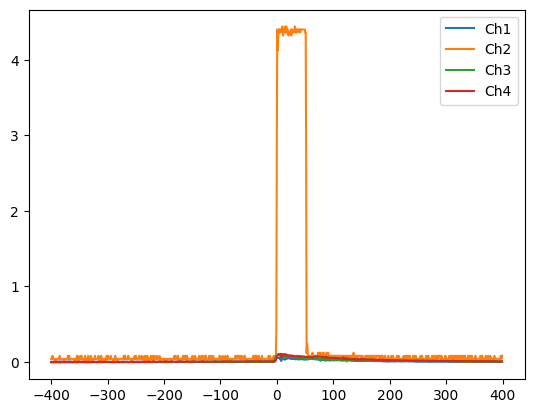

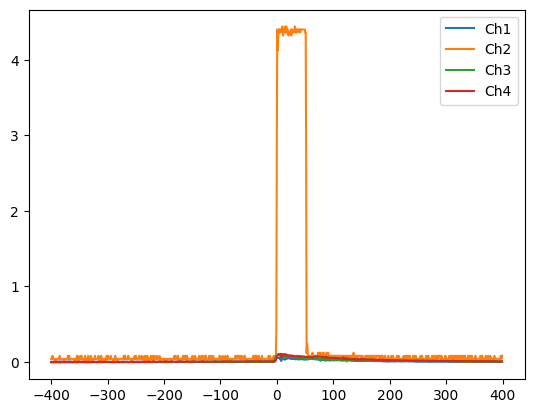

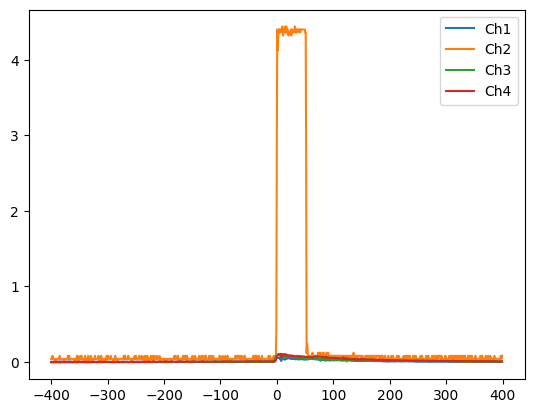

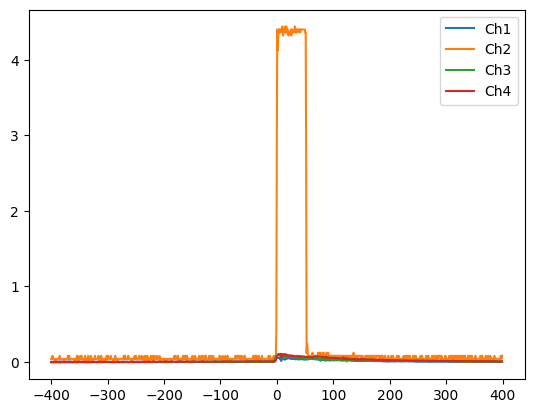

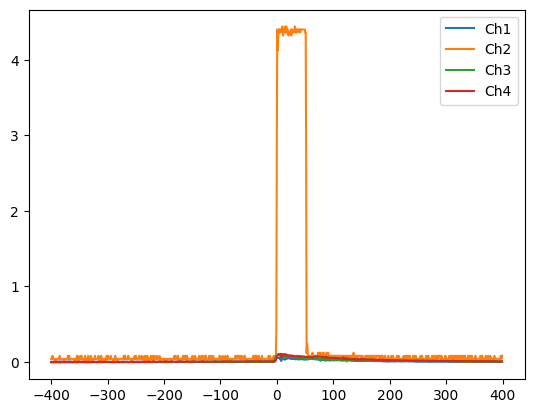

In [64]:
timeax = np.array([(runconfig[0]['x_zero'] +  t*runconfig[0]['x_inc'])*1.e9 for t in range(1000)])

selected = np.random.choice(len(pulses), 5, replace=False)
print(selected)
pulses = np.array(pulses)
for curves in pulses[selected]:
    plt.figure()
    for i in range(len(curves)):
        plt.plot(timeax, curve[i], label=f"Ch{i+1}")
    plt.legend()
    plt.show()